## Concept Labeling

Select the model to use for concept labeling, in this case, the PrototypeAESeqSleepNet. There is a pre-trained version of this model in train/model/checkpoints, trained on several merged datasets (SHHS, MASS, DCSM, MROS, MESA, HMC).

Define the model class to be used in the concept labeler and its corresponding configuration parameters.

In [1]:
import os
import importlib
# select the model to use for concept labeling, in this case the PrototypeAESeqSleepNet 
model_class = "physioex.train.networks.protoae_seqsleepnet:PrototypeAESeqSleepNet"
module_name, class_name = model_class.split(":")
model_class = getattr(importlib.import_module(module_name), class_name)

Define the datamodule that will be used to load the the dataset you want to extend with concepts

In [2]:
from physioex.train.networks import config as networks_config
model_config = networks_config["default"]["model_kwargs"].copy()
datamodule_kwargs = {
    "selected_channels": ["EEG"],
    "sequence_length": 3,
    "target_transform": None, # needs to match model output
    "preprocessing": "xsleepnet", # needs to match model input
    "data_folder": "/mnt/guido-data/", # your custom path here
    "num_workers": os.cpu_count(), # default value
}
# now setup the ones that depends on the datamodule
model_config.update({
    "in_channels" : len(datamodule_kwargs["selected_channels"]),
    "sequence_length" : datamodule_kwargs["sequence_length"],
})


Instantiate the concept labeler with the model and the datamodule you want to use, then you can run it using the run method

In [3]:
from physioex.explain.concepts.concept_labeler import ConceptLabeler

concept_labeler = ConceptLabeler(
    dataset_name="mass",
    data_folder="mnt/guido-data/",
    model_class=model_class,
    model_config=model_config,
    model_ckpt_path="/home/manni/physioex/models/protoae_seqsleepnet/protoae_ssn6612_shhs_l3_eeg/fold=-1-epoch=7-step=231968-val_loss=6.80.ckpt",
    #model_ckpt_path=None,
    channels_index=[0],
    sequence_length=3
)

concept_labeler.run()

2024-10-29 18:18:26.034 | INFO     | physioex.explain.concepts.concept_labeler:run:68 - Running the concept labeler ...
2024-10-29 18:18:26.036 | INFO     | physioex.explain.concepts.concept_labeler:run:77 - Computing the distances ...
100%|██████████| 201/201 [01:03<00:00,  3.16it/s]
2024-10-29 18:19:29.724 | INFO     | physioex.explain.concepts.concept_labeler:run:117 - Computing the concepts ...
100%|██████████| 200/200 [00:21<00:00,  9.35it/s]


## Concept Models Training

In [2]:
from physioex.train.utils import train
from physioex.train.models import load_model
import os

In [3]:
# Note the best practice is to use a yaml file to store the arguments
# datamodule arguments

datamodule_kwargs = {
    "batch_size": 128,
    "selected_channels": ["EEG"],
    "sequence_length": 3,
    "target_transform": None, # needs to match model output
    "preprocessing": "xsleepnet", # needs to match model input
    "data_folder": "/mnt/guido-data/", # your custom path here
    "num_workers": os.cpu_count(), # default value
    #"num_workers": 1, # default value
    "concepts": True,
}

# let's use the standard approach to load the model, can be any SleepModule
# you can use it also in a .yaml file

#model_class = "physioex.train.networks.seqsleepnet:SeqSleepNet"
model_class = "physioex.train.networks.seqsleepnet_cem:SeqSleepNetCEM"

import importlib
module_name, class_name = model_class.split(":")
model_class = getattr(importlib.import_module(module_name), class_name)

# now we need to define the model parameters, 
# these should be passed in the constructor of the model as a dictionary "model_config"

# first read the default parameters from physioex
from physioex.train.networks import config as networks_config
model_config = networks_config["default"]["model_kwargs"].copy()

# now we can modify the parameters as we want, first using the specific parameters for the model
if "model_kwargs" in networks_config["seqsleepnet_cem"]:
    model_config.update(networks_config["seqsleepnet_cem"]["model_kwargs"])

# now setup the ones that depends on the datamodule
model_config.update({
    "in_channels" : len(datamodule_kwargs["selected_channels"]),
    "sequence_length" : datamodule_kwargs["sequence_length"],
})

train_kwargs = {
    "datasets": "mass", # dataset to use, can be also a PhysioExDataModule
    "datamodule_kwargs": datamodule_kwargs,
    "model_class": model_class,
    "model_config": model_config,
    "batch_size": 128,
    "num_validations": 1, # number of validations to perform per epoch
    "checkpoint_path": "/home/manni/physioex/models/concept_usage/", # path to save the model
    "max_epochs": 15,
    "resume": False, # if the train sees a checkpoint it will resume from there
    "monitor": "val_loss", # metric to use to save the best model
    "monitor_mode": "min", # mode to use to save the best model
}

In [3]:
# now we can train the model

best_checkpoint = train( **train_kwargs )

best_checkpoint = os.path.join( train_kwargs["checkpoint_path"], best_checkpoint )

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/manni/physioex/models/concept_usage exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                 | Params | Mode 
--------------------------------------------------------------
0 | nn           | Net                  | 144 K  | train
1 | loss_class   | CrossEntropyLoss     | 0      | train
2 | acc_class    | MulticlassAccuracy   | 0      | train
3 | wf1_class    | MulticlassF1Score    | 0      | train
4 | mf1_class    | MulticlassF1Score    | 0      | train
5 | ck_class     | MulticlassCohenKappa | 0      | train
6 | pr_class     | MulticlassPrecision  | 0      | train
7 | rc_class     | MulticlassRecall     | 0      | train
8 | mse          | MSELoss              | 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [4]:
# now we should (optional) load and test the model on the test split of the dataset
best_checkpoint = "/home/manni/physioex/models/concept_usage/fold=-1epoch=14-step=23621-val_loss=1.06.ckpt"

model = load_model(
    model = model_class,
    model_kwargs = model_config,
    ckpt_path = best_checkpoint,
)

## Results Visualization

In [5]:
from physioex.explain.concepts import visualization as vis
from physioex.explain.concepts import emb_extraction as emb

from physioex.data import PhysioExDataModule

data = PhysioExDataModule(datasets=["mass"], **datamodule_kwargs).test_dataloader()

In [6]:
emb_array, labels_array, con_array, mse_array, con_emb_array = emb.compute_embedding_ssn_cem(model, data)

100%|██████████| 89/89 [00:01<00:00, 69.70it/s]


Mean of each column: [0.0044121  0.0022223  0.00078474 0.00210592 0.00234109 0.00227869
 0.00316368 0.00418871 0.00122313 0.00300627 0.00180518 0.00328807
 0.00054678 0.00627093 0.00433441]
Standard deviation of each column: [0.01414324 0.0075031  0.00401931 0.00743994 0.01090051 0.00876324
 0.01031692 0.01420984 0.005813   0.01235743 0.01059842 0.01281205
 0.00299191 0.01733242 0.01334492]
Percentage of outliers in each column: [17.07165662 15.85668677 18.88967719 18.40191557 14.34905995 16.34444839
 17.84320681 15.60837176 18.63249379 14.85455835 15.5640298  17.25789287
 18.94288755 17.40865555 16.67257893]
Percentage of big values in each column: [3.80454062 1.18836467 0.36360411 1.42781128 1.85349415 2.12841433
 2.4210713  3.27243703 0.85136573 2.35012416 1.61404753 2.61617595
 0.19510465 6.68676836 3.8222774 ]


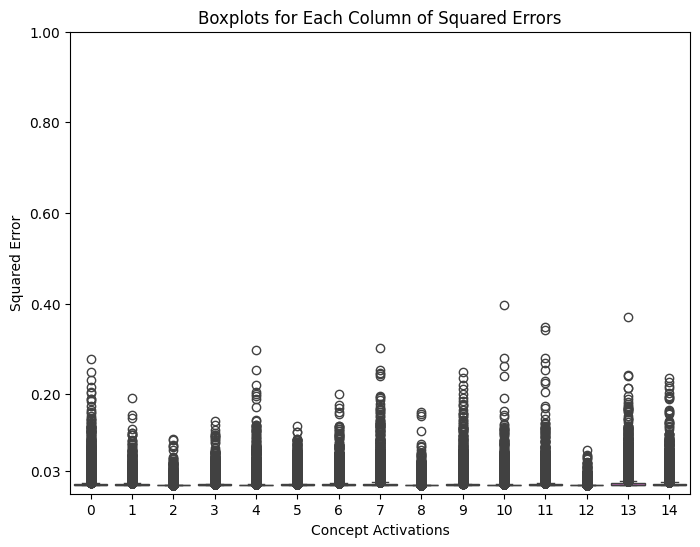

In [7]:
vis.concept_boxplots(mse_array)

Explained variance by component 1: 0.26
Explained variance by component 2: 0.17


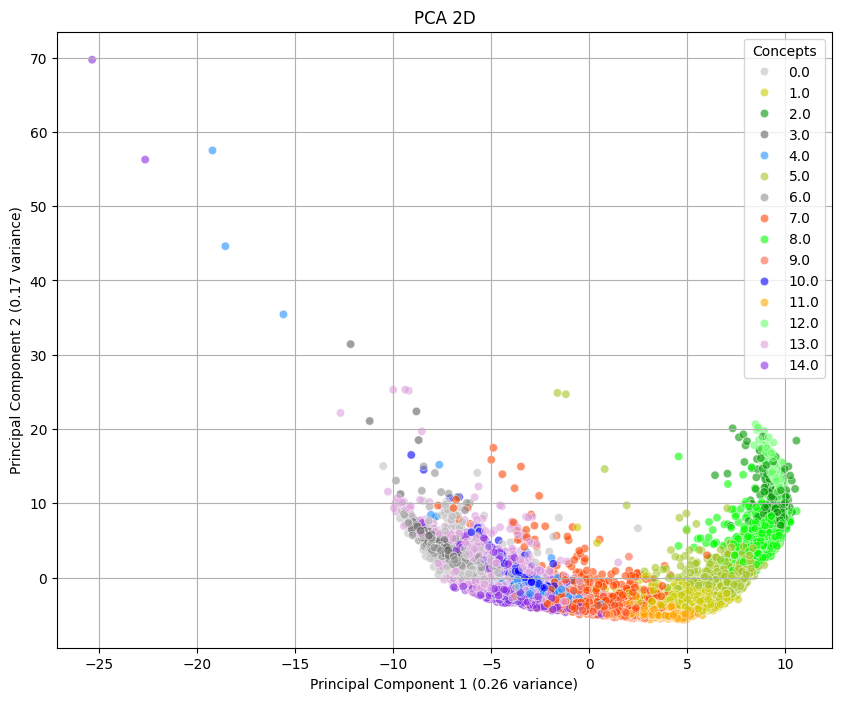

In [8]:
vis.plot_pca_2d(emb_array, con_array, p_palette=vis.concept_palette, percentage=1, legend_title="Concepts")

Explained variance by component 1: 0.38
Explained variance by component 2: 0.22


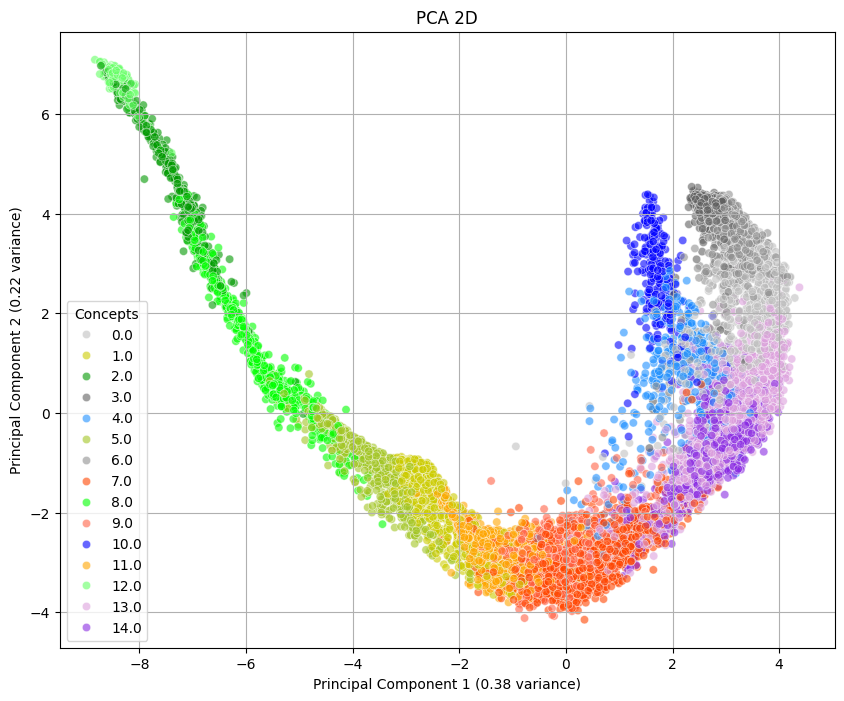

In [9]:
vis.plot_pca_2d(con_emb_array, con_array, p_palette=vis.concept_palette, percentage=1, legend_title="Concepts")

Explained variance by component 1: 0.38
Explained variance by component 2: 0.22


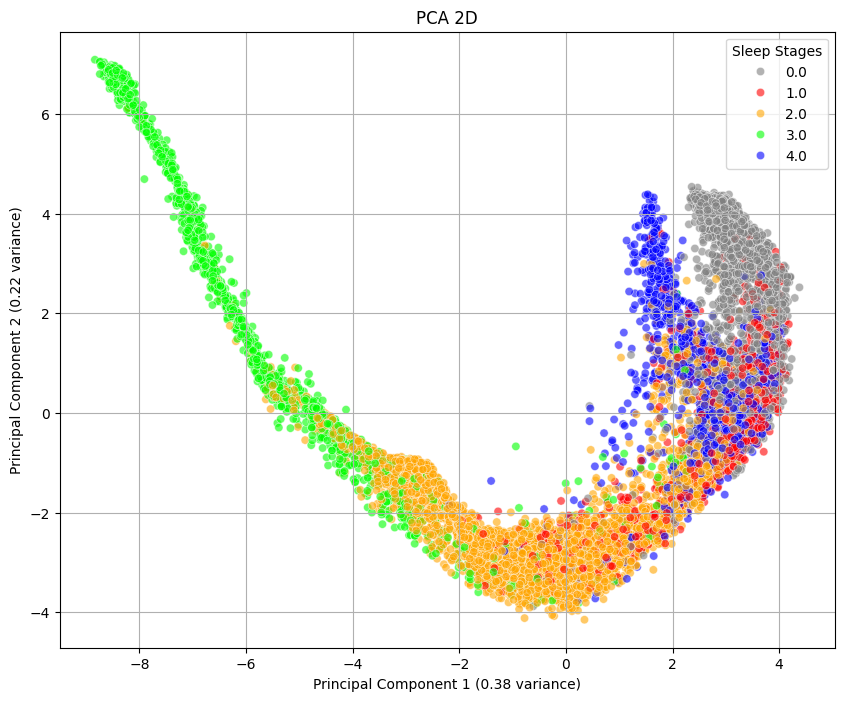

In [10]:
vis.plot_pca_2d(con_emb_array, labels_array, percentage=1)